# Practical Machine Learning for Physicists
## Introduction to backpropagation

Backpropagation sounds very confusing but it is actually just the chain rule in action. In this notebook we will implement our own version of backpropagation to train our simple neural network model from last week.

A reminder in a single layer (labelled by $l$) of our network the output of a given neuron (labelled with $i$) is called $y^{l}_i$ and depends on some weights ($w$) and bias ($b$) and the output of the previous layer $l-1$:
$$y^{l}_i = f( \sum_j w^l_{ij} y^{l-1}_j + b^{l}_i) = f( z^l_i)$$ 
where $f$ is our non-linear activation function and we have introduced 
$$ z^l_i = \sum_j w^l_{ij} y^{l-1}_j + b^{l}_i$$


Now lets assume there are $N$ layers in our network so one of the outputs of the final layer will be $y^N_i$. Using these outputs we will calculate some (as yet to be defined) cost function that could be the mean square error or the chi-squared or some other suitable cost function ($L$).

We will now introduce $\Delta^l_i$ which is called the error of neuron $i$ in layer $l$ and shows how the cost function changes with this neuron.
$$\Delta^l_i \equiv \frac{\partial L}{\partial z^l_i} = \frac{\partial L}{\partial y^l_i} f^\prime(z^l_i)$$
As we did in the simple curve fitting case we want to differentiate our cost function ($L$) with respect to our parameters, the weights ($w$) and biases ($b$). So we want to find:
$$  \frac{\partial L}{\partial b^l_i} = \frac{\partial L}{\partial z^l_i} \frac{\partial z^l_i}{\partial b^l_i} =\frac{\partial L}{\partial z^l_i} $$
since $\frac{\partial z^l_i}{\partial b^l_i}=1$.





Now we know that the cost function only depends on the neurons in layer $l$ through their influence on layer $l+1$. So we can use the chain rule again.
$$  \Delta^l_i  =\frac{\partial L}{\partial z^l_i} = \sum_j \frac{\partial L}{\partial z^{l+1}_j} \frac{\partial z^{l+1}_j}{\partial z^l_i} $$
but from above
$$ \frac{\partial L}{\partial z^{l+1}_j} = \Delta^{l+1}_j$$ 
and
$$ \frac{\partial z^{l+1}_j}{\partial z^l_i} = \frac{\partial z^{l+1}_j}{\partial y^l_i}\frac{\partial y^l_i}{\partial z^l_i} = w^{l+1}_{ij} f^\prime(z^l_i)$$
where $f^\prime$ is the derivative of the activation function $f$.
Giving the backpropagation equation:
$$ \Delta^l_i  = \left( \sum_j  \Delta^{l+1}_j w^{l+1}_{ij} \right) f^\prime(z^l_i) $$

We will also need to know how the cost function ($L$) depends on the weights, so we will need
$$ \frac{\partial L}{\partial w^{l}_{ij}} = \frac{\partial L}{\partial z^l_i}\frac{\partial z^l_i}{\partial w^{l}_{ij}} = \Delta^{l}_i y^{l-1}_j $$

### Backpropagation algorithm
1. For a given input $x$ evaluate the network, this will involve calculating all $y^l_i$ and $z^l_i$
2. Calculate the cost function $L$ using the outputs of the final layer $y^N_i$
3. Calculate the error in the cost function relative to the final layer $z^N_i$, this step will require the derivative of the cost function and activation function.
4. Backpropagate the error using the backpropagation equation above.
5. Then using the above equations evaluate the gradients $\frac{\partial L}{\partial w^{l}_{ij}}$ and $\frac{\partial L}{\partial b^{l}_j}$

## Backpropagation in action
We are going to implement a fully connected neural network of the form
$$y^{l}_i = f( \sum_j w^l_{ij} y^{l-1}_j + b^{l}_i)$$

Initially we will use the sigmoid as our activation function:
$$f_{sigmoid}(x) = \frac{1}{ 1 + e^{-x}}$$
so
$$ \frac{df}{dx} = \frac{e^{-x}}{\left(1+e^{-x}\right)^2} = e^{-x} f^2$$


In [1]:
#So now we will have our first bit of code
import numpy as np  #import the numpy library as np
import matplotlib.pyplot as plt #import the pyplot library as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=150 # dots per inch

In [2]:

class SimpleNN:
    """A simple neural network class"""
    #Define and initialise our class variables  
    def __init__(self,nLayers,nBatch,layerSize,useRELU=False,wMax=1,bMax=1):
        self.nlayers=nLayers
        self.batchsize=nBatch
        self.layersize=layerSize
        self.useRELU=useRELU
        
        #Initialise the weights and biases with random numbers
        self.w=[np.random.uniform(low=-1*wMax,high=+1*wMax,size=[ self.layersize[j],self.layersize[j+1] ]) for j in range(self.nlayers)]
        self.b=[np.random.uniform(low=-1*bMax,high=+1*bMax,size=[ self.layersize[j+1] ]) for j in range(self.nlayers)]
        
        #Define the arrays for various outputs needed for backpropagation
        self.yArray=[np.zeros([self.batchsize,self.layersize[j]]) for j in range(self.nlayers+1)]
        self.dfArray=[np.zeros([self.batchsize,self.layersize[j+1]]) for j in range(self.nlayers)]
        self.dwArray=[np.zeros([self.layersize[j],self.layersize[j+1]]) for j in range(self.nlayers)]
        self.dbArray=[np.zeros(self.layersize[j+1]) for j in range(self.nlayers)]
    
    
    #This function evaluates both the neuron output funciton f(x), but also gets df/dx(x)
    def get_f_df(self,x):  
        emx=np.exp(-x) 
        f=1./(1+emx) #Sigmoid
        df=emx*f*f #df/dx
        return (f,df) #Return both
    
    # For a change: Set up rectified linear units (relu) 
    # instead of sigmoid
    def get_f_df_relu(self,z): # calculate f(z) and f'(z)
        val=z*(z>0)
        return(val,z>0) # return both f and f'

    #Evaluate one layer step of the network 
    def forward_step(self,y,w,b):
        z=np.dot(y,w)+b  #Calculate z from the inputs, weights and biases
        #Remember y has shape (Nbatch x Layer Size N)
        # w has shape (Layer Size N x Layer Size N+1)
        # b has shape (Layer Size N+1)
        # z has shape (Nbatch x Layer Size N+1) 
        if(self.useRELU):
            return self.get_f_df_relu(z) #Get f(z) and df/dz(z)
        return self.get_f_df(z) #Get f(z) and df/dz(z)

    def network_forward(self,yin):
        y=yin # start with input values which have shape (batch size x input layer size)
        self.yArray[0]=y 
        for i in range(self.nlayers):  #Loop over the self.nlayers of the network
            y,df=self.forward_step(y,self.w[i],self.b[i]) #Take one step forward in the network
            self.yArray[i+1]=y   #Store y for backpropagation
            self.dfArray[i]=df #Stor df for backpropagation
        return y
    
    def backward_step(self,delta,w,df):
        #delta is the error at layer N of shape (Nbatch x layer N output size)
        #w is the weights at layer N of shape (layer N-1 output size x layer N output size)
        #df has shape (Nbatch x layer N-1 output size)
        return (np.dot(delta,np.transpose(w))*df)

    def backpropagate(self,yTarget):
        #This function fills the dwArray and dbArray arrays with the gradients at each layer
    
        #Evaluate error at last layer
        delta=(self.yArray[-1]-yTarget)*self.dfArray[-1]
        self.dwArray[-1]=np.dot(np.transpose(self.yArray[-2]),delta)/self.batchsize
        self.dbArray[-1]=delta.sum(0)/self.batchsize
        for i in range(self.nlayers-1):
            delta=self.backward_step(delta,self.w[-1-i],self.dfArray[-2-i])
            self.dwArray[-2-i]=np.dot(np.transpose(self.yArray[-3-i]),delta)/self.batchsize
            self.dbArray[-2-i]=delta.sum(0)/self.batchsize
            
    #Update the weights and biases using the gradients and learning rate (eta)
    def update_with_gradients(self,eta):
        for i in range(self.nlayers):
            self.w[i]-=eta*self.dwArray[i]
            self.b[i]-=eta*self.dbArray[i]
   
    #Function that evaluates one pass through the network using input yIn
    #Then backpropagates the errors through the network to update the weights and biases
    def train_network(self,yIn,yTarget,eta):
        yOut=self.network_forward(yIn)
        self.backpropagate(yTarget)
        self.update_with_gradients(eta)
        cost=((yTarget-yOut)**2).sum()/self.batchsize
        return(cost)
    
   

### Set up a network and run it

In [3]:
#Need to define the network
myNN = SimpleNN(nLayers=3,nBatch=100,layerSize=[2,20,30,1])

## Train the network on one batch repeatedly (this isn't a good idea)

In [4]:
yIn=np.random.uniform(low=-1,high=+1,size=[myNN.batchsize,myNN.layersize[0]])
yTarget=np.random.uniform(low=-1,high=+1,size=[myNN.batchsize,myNN.layersize[-1]])

In [5]:
eta=0.001
numSteps=2000
cost=np.zeros(numSteps)
for step in range(numSteps):
    cost[step]=myNN.train_network(yIn,yTarget,eta)

Text(0, 0.5, 'Cost')

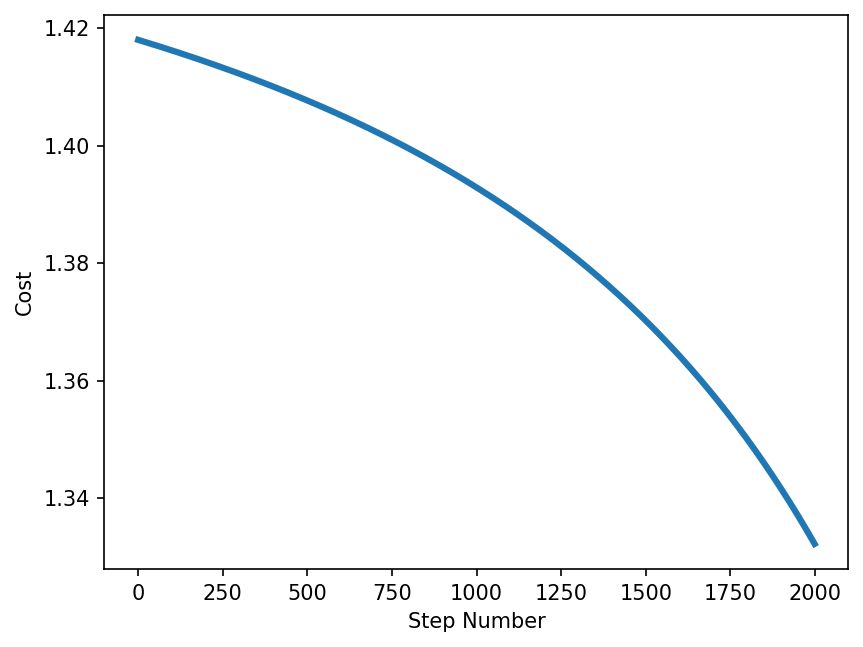

In [6]:
#Actually plot something
fig, ax = plt.subplots()  #I like to make plots using this silly fig,ax method but plot how you like
stepArray=np.arange(numSteps) #Get numbers 0-199
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")

## Use random batches

In [7]:
#Define a new fresh network
myNN = SimpleNN(nLayers=2,nBatch=100,layerSize=[2,200,1],useRELU=True,wMax=0.1,bMax=0)

Text(0.5, 1.0, 'Input Image')

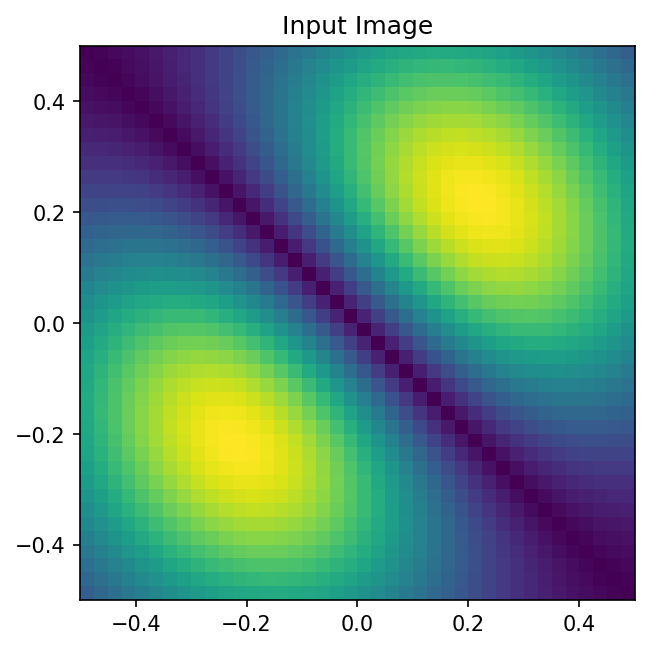

In [8]:
#Define a 2D function with some abritrary shape
def myFunc(x0,x1):
    r2=x0**2+x1**2
    return(np.exp(-5*r2)*np.abs(x1+x0))

xrange=np.linspace(-0.5,0.5,40)
X0,X1=np.meshgrid(xrange,xrange)
fig, ax = plt.subplots()
ax.imshow(myFunc(X0,X1),extent=(-0.5,0.5,-0.5,0.5),interpolation='nearest',origin='lower')
ax.set_title("Input Image")

In [9]:
#This function picks batchsize random x,y pairs and then evaluates myFunc for these x,y pairs
# returns both the x,y pairs and the values
def make_batch(batchsize):
    inputs=np.random.uniform(low=-0.5,high=+0.5,size=[batchsize,2])
    targets=np.zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
    return(inputs,targets)

Text(0.5, 1.0, 'Start Image')

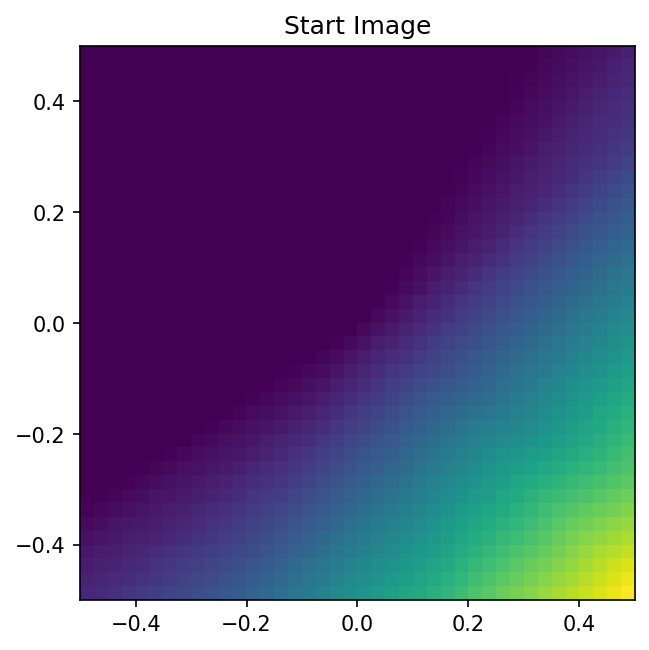

In [10]:
# try to evaluate the (randomly initialized) network
# on some area in the 2D plane
test_batchsize=np.shape(X0)[0]*np.shape(X0)[1]
testsample=np.zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

testoutput=myNN.network_forward(testsample)
fig, ax = plt.subplots()
myim=ax.imshow(np.reshape(testoutput,np.shape(X0)),extent=(-0.5,0.5,-0.5,0.5),origin='lower',interpolation='none')
ax.set_title("Start Image")

Text(0.5, 1.0, 'Cost function during training')

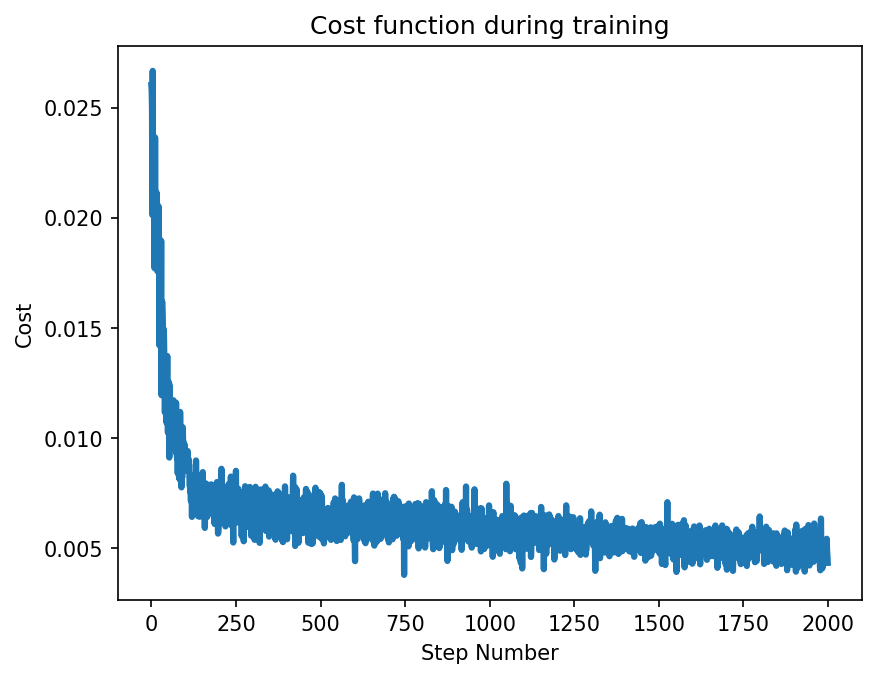

In [11]:
#Define our learning rate and number of learning steps and make an array for the cost function per step
eta=.01
steps=2000
cost=np.zeros(steps)

#Loop through the steps, get a random batch of samples, train the network, repeat
for k in range(steps):
    y_in,y_target=make_batch(myNN.batchsize)
    cost[k]=myNN.train_network(y_in,y_target,eta)

#Plot the output image
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")
ax.set_title("Cost function during training")


Text(0.5, 1.0, 'Current Network Image')

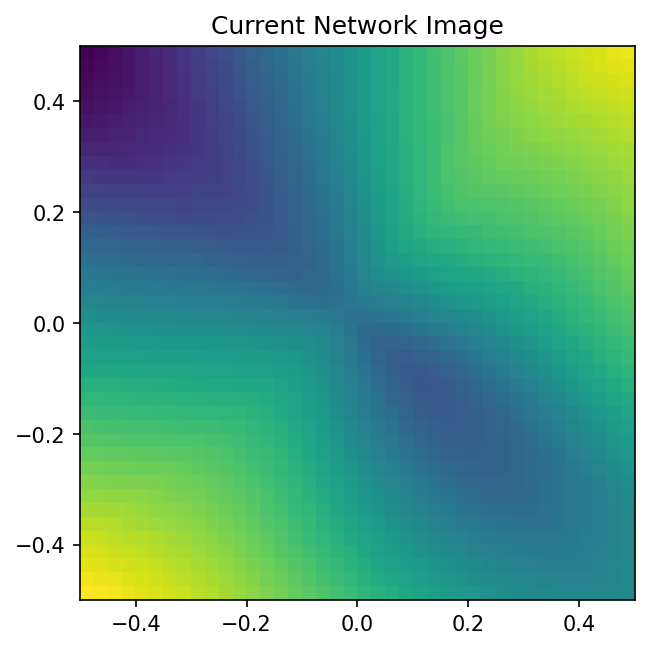

In [12]:
#Now plot the final result... does it look somewhat like the input image?
testoutput=myNN.network_forward(testsample)
fig, ax = plt.subplots()
myim=ax.imshow(np.reshape(testoutput,np.shape(X0)),extent=(-0.5,0.5,-0.5,0.5),origin='lower',interpolation='none')
ax.set_title("Current Network Image")


In [32]:
# start fresh by making a new neural network object
myNN = SimpleNN(nLayers=2,nBatch=100,layerSize=[2,100,1],useRELU=True,wMax=0.1,bMax=0)

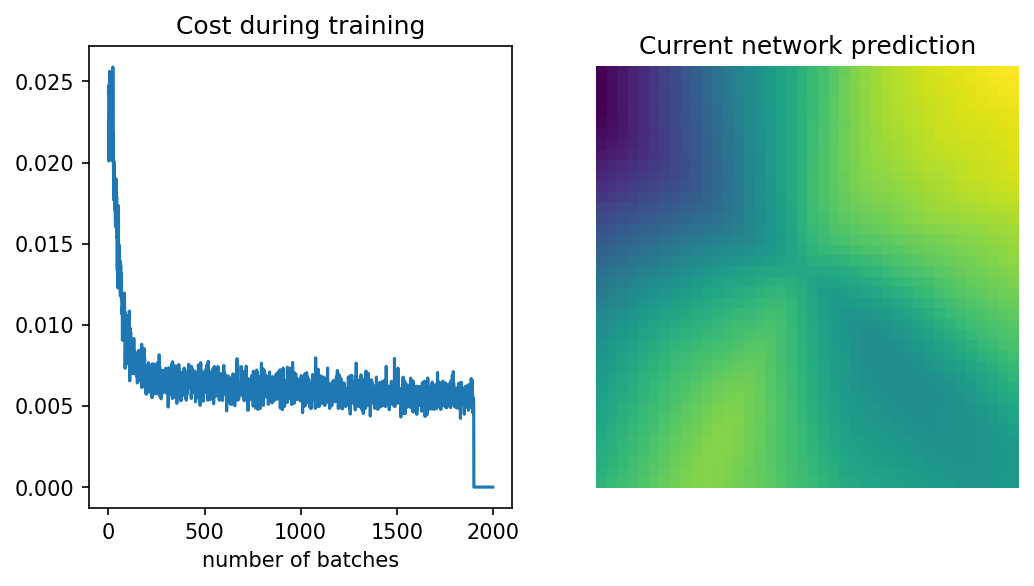

In [33]:
# import functions for updating display 
# (simple animation)
from IPython.display import clear_output
from time import sleep

eta=0.01 # learning rate
nsteps=2000  #Number of steps in the training
updateEvery=100  #Only update the plot every 100 steps (just to speed things up)
costs=np.zeros(nsteps)
for j in range(nsteps):
    
     # the crucial lines:
    y_in,y_target=make_batch(myNN.batchsize) # random samples (points in 2D)
    costs[j]=myNN.train_network(y_in,y_target,eta) # train network (one step, on this batch)
    
    if j%updateEvery ==0:
        clear_output(wait=True)
        fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4)) # prepare figure
        ax[1].axis('off') # no axes
    
   
        testoutput=myNN.network_forward(testsample) # check the new network output in the plane
        img=ax[1].imshow(np.reshape(testoutput,np.shape(X0)),interpolation='nearest',origin='lower') # plot image
        ax[0].plot(costs)
    
        ax[0].set_title("Cost during training")
        ax[0].set_xlabel("number of batches")
        ax[1].set_title("Current network prediction")
        plt.show()
        #sleep(0.1)

# Suggested Tasks:
1. Can you improve the quality of the functional represenation above? Potential things to change are the number of training epochs, the learning rate, the number of neurons in the hidden layer and the number of hidden layers
2. What other functions could you try and replicate using a neural network?